In [1]:
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from easydict import EasyDict as edict
from collections import defaultdict as ddict
import torch
import time
from tqdm.autonotebook import tqdm
from scipy import signal
import time
%matplotlib inline
import pickle

In [2]:
from cUtils import *
from Rfuns import bw_nrd0_R
from tmpUtils import *

In [3]:
dataPath = Path("../data")

In [190]:
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)

def GetAmatTorch(Y, X, times, freqs, downrates=[1], hs=None):
    """
    Input: 
        Y: A tensor with shape, d x dF x dT
        X: A tensor with shape, d x dF x dT
        times: A list of time points with length dT
        freqs: A list of frequency points with length dF
        downrates: The downrate factors for freq and time, determine how many A(s_i, t_i) matrix to be summed
        hs: the bandwidths for the kernel regression.
    Return:
        A d x d matrix, it is sum of dF x dT/downrates  A(s_i, t_i) matrix
    """
    d, dF, dT = X.shape
    if hs is None:
        hs = [bw_nrd0_R(freqs), bw_nrd0_R(times)]
    hF, hT = hs
    if len(downrates) == 1:
        DRF = DRT = downrates
    else:
        DRF, DRT = downrates
        
    Ytrans = Y.permute((1, 2, 0))
    Xtrans = X.permute((1, 2, 0))
        
    Amat = torch.zeros(d, d)
    Amats = ddict(list)
    for idxf, fs in enumerate(freqs[::DRF]):
        for idxt, ts in enumerate(times[::DRT]):
            t_diff = times - ts
            freqs_diff = freqs- fs
            
            kernelst = 1/np.sqrt(2*np.pi) * np.exp(-t_diff**2/2/hT**2) # normal_pdf(x/h)
            kernelsf = 1/np.sqrt(2*np.pi) * np.exp(-freqs_diff**2/2/hF**2) # normal_pdf(x/h)
            kernelst = torch.tensor(kernelst)
            kernelsf = torch.tensor(kernelsf)
            # kernelsf = torch.ones_like(kernelsf)
            
            kernelroot = (kernelsf.unsqueeze(-1) * kernelst)  ** (1/2) #  dF x dT
            
            kerY = kernelroot.unsqueeze(-1)* (Ytrans) # dF x dT x d
            kerX = kernelroot.unsqueeze(-1) * (Xtrans) # dF x dT x d
            kerYmat = kerY.reshape(-1, d)
            kerXmat = kerX.reshape(-1, d)
            
            M = kerXmat.T.mm(kerXmat)/dF/dT
            XY = kerYmat.T.mm(kerXmat)/dF/dT
            
            invM = torch.inverse(M)
            Amats[idxf].append((XY.mm(invM)).cpu().numpy())
            Amat = Amat + XY.mm(invM)
    return np.array(Amat.cpu()), Amats

### Load the Amat from real data

In [191]:
if torch.cuda.is_available():
    torch.set_default_tensor_type(torch.cuda.DoubleTensor)

In [192]:
realPath = dataPath/"realmat.pkl"
if realPath.exists():
    with open(realPath, "rb") as f:
        real = pickle.load(f)
else:
    datF = list(dataPath.glob("*.mat"))[0]
    rawDat = loadmat(datF)
    dat = rawDat["DK_timecourse"]
    fs = 600
    q = 50
    nDat = mat2Tensor(dat, fs=fs, q=q)
    bandsCuts = [[2, 3.5], [4, 7], [8, 12], [13, 30], [30, 80]]
    downrates = [1, 1]
    hs = [0.1, 0.1]
    T = 60
    _, dF, dT = nDat.Y.shape
    times = np.linspace(0, T, dT)
    freqs = np.array([np.mean(bandCut) for bandCut in bandsCuts])
    Amat = GetAmatTorch(torch.tensor(nDat.Y.copy()), torch.tensor(nDat.X.copy()), times, freqs, downrates, hs)
    
    res = np.linalg.eig(Amat)
    absEigVs = np.abs(res[0])
    # Sort the eigvs and vectors such that the vals is in order
    sortIdx = np.argsort(absEigVs)[::-1]
    lams = res[0][sortIdx]
    U = res[1][:, sortIdx]
    
    real = edict()
    real["Amat"] = Amat
    real["U"] = U
    real["eigVs"] = lams
    real["X"] = nDat.X
    real["Y"] = nDat.Y
    
    with open(realPath, "wb") as f:
        pickle.dump(real, f)

In [303]:
dF = 5
dT = 719
nR = 6
T = 6
ChgsFreq = []
ChgsT = [100]
d = real.U.shape[0]

In [304]:
eigIndAll = real.eigVs.imag != 0
ChgsTF = np.concatenate([[0], ChgsT, [dT]])
ChgsFreqF = np.concatenate([[0], ChgsFreq, [dF]])
ChgsFreqF = ChgsFreqF.astype(np.int)
ChgsTF = ChgsTF.astype(np.int)

In [305]:
Mus = GenFVecs(nR, eigIndAll[:nR], ChgsFreqF)
Nus = GenFVecs(nR, eigIndAll[:nR], ChgsTF)
idx1 = ChgsFreqF[1]
Mus[:, 0:idx1].imag = 0
stdMus =  Mus /np.linalg.norm(Mus, axis=1).reshape(-1, 1)

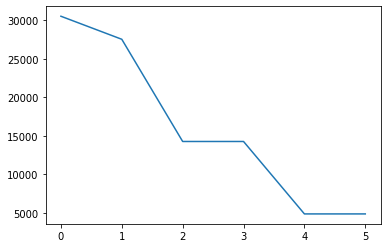

In [306]:
tMNs = stdMus.reshape(-1, 1, 5) * Nus.reshape(nR, -1, 1)
plt.plot(np.abs(tMNs).sum(axis=(1, 2)))

In [307]:
num = 68
X = real.X[:num, :dF, :dT]
Y = np.zeros_like(X)
U = real.U[:num, :num]
invU = np.linalg.inv(U)
tAmat = 0
tAmats = ddict(list)
cAr = np.random.randint(0, 100, (num, num))
pEigVs = stdMus[:, 0] * Nus[:, 0]
for df in range(dF):
    for dt in range(dT):
        cX = X[:, df, dt]
        cMu = stdMus[:, df]
        cNu = Nus[:, dt]
        pEigVs = cMu * cNu
        # sortIdx = np.argsort(np.abs(pEigVs))[::-1]
        cEigVs = np.diag(np.concatenate([pEigVs, np.zeros(num - len(cMu))]))
        cA = np.matmul(np.matmul(U, cEigVs), invU)
        cAr = cA.real # theroetically, imag part should be 0
        cY = np.matmul(cAr, cX) #+ 0*np.random.randn(d)
        Y[:, df, dt] = cY
        tAmats[df].append(cAr)
        tAmat = cAr + tAmat

### Test the Amat

In [318]:
d, dF, dT = X.shape
T = 6
bandsCuts = [[2, 3.5], [4, 7], [8, 12], [13, 30], [30, 80]]
times = np.linspace(0, T, dT)
freqs = np.array([np.mean(bandCut) for bandCut in bandsCuts])
hs = [bw_nrd0_R(freqs), bw_nrd0_R(times)*2]
print(hs)
# hs = [10, 0.5]

[7.788676982805086, 0.8382886837369563]


In [321]:
Xt = torch.tensor(X)
Yt = torch.tensor(Y)
Amat, Amats = GetAmatTorch(Yt, Xt, times, freqs, [1, 10], hs=hs)

In [320]:
for df in range(dF):
    for dt in range(dT):
        ctA = tAmats[df][dt]
        ceA = Amats[df][dt]
        print(df, dt, np.linalg.norm(ctA-ceA))

0 0 649.4743063296785
0 1 649.6258971294245
0 2 649.7806104613015
0 3 649.9382385929374
0 4 650.0985764775634
0 5 650.2614170363007
0 6 650.4265564768058
0 7 650.5937892511636
0 8 650.7629115673867
0 9 650.9337210293113
0 10 651.1060146901976
0 11 651.279591315378
0 12 651.4542500845322
0 13 651.6297924839116
0 14 651.8060207206554
0 15 651.9827372559278
0 16 652.1597481624126
0 17 652.3368581854396
0 18 652.513875819788
0 19 652.6906101457602
0 20 652.8668709715353
0 21 653.0424713304747
0 22 653.2172255795086
0 23 653.3909486840905
0 24 653.5634586076231
0 25 653.7345740947151
0 26 653.9041168791533
0 27 654.0719089355248
0 28 654.2377755545048
0 29 654.4015429832641
0 30 654.5630397936798
0 31 654.7220953433621
0 32 654.8785423470201
0 33 655.0322140887786
0 34 655.1829462293546
0 35 655.3305760633978
0 36 655.4749414355465
0 37 655.6158841127349
0 38 655.753245945438
0 39 655.8868700892855
0 40 656.0166018879764
0 41 656.1422883308735
0 42 656.2637766151151
0 43 656.3809163754914
0

0 407 9.249131561479508
0 408 9.121620916560024
0 409 8.994795833306929
0 410 8.868518574117761
0 411 8.742664519818348
0 412 8.617121889736927
0 413 8.491791416013864
0 414 8.366586023056449
0 415 8.241430467227717
0 416 8.116260967013547
0 417 7.99102482190971
0 418 7.865680004725476
0 419 7.740194760867038
0 420 7.614547164756699
0 421 7.488724699142711
0 422 7.3627237985439775
0 423 7.2365493968692105
0 424 7.1102144618312195
0 425 6.983739522883946
0 426 6.857152192670088
0 427 6.730486685079293
0 428 6.603783328848643
0 429 6.4770880699261815
0 430 6.3504519891980715
0 431 6.223930803295709
0 432 6.097584373248406
0 433 5.971476221410801
0 434 5.845673037441961
0 435 5.720244207001583
0 436 5.595261335988
0 437 5.470797790026884
0 438 5.346928235034384
0 439 5.223728206605196
0 440 5.101273678831568
0 441 4.97964064893039
0 442 4.858904752193546
0 443 4.739140874690616
0 444 4.620422806108315
0 445 4.502822898859586
0 446 4.386411751942061
0 447 4.271257924001901
0 448 4.15742765

1 105 630.0363395511948
1 106 629.5193380410882
1 107 628.9858025219029
1 108 628.4353888230817
1 109 627.8677474801917
1 110 627.2825237472849
1 111 626.6793582817255
1 112 626.0578870115186
1 113 625.4177411017192
1 114 624.7585472203518
1 115 624.0799281683188
1 116 623.3815023528039
1 117 622.6628844869191
1 118 621.9236857640428
1 119 621.1635140979045
1 120 620.3819741465317
1 121 619.5786676480425
1 122 618.7531938827668
1 123 617.9051497586065
1 124 617.0341302737545
1 125 616.1397284081228
1 126 615.2215359342648
1 127 614.2791432432479
1 128 613.3121400836459
1 129 612.3201155740365
1 130 611.3026585857164
1 131 610.2593583052543
1 132 609.1898041951017
1 133 608.0935864560286
1 134 606.9702968170417
1 135 605.8195282493334
1 136 604.6408753408085
1 137 603.4339354764437
1 138 602.1983081975425
1 139 600.9335962056441
1 140 599.6394055042567
1 141 598.3153456463863
1 142 596.9610306260358
1 143 595.5760785801548
1 144 594.160112576115
1 145 592.7127612478091
1 146 591.2336583

1 564 0.031655325138930025
1 565 0.030148852230345417
1 566 0.028713080700053944
1 567 0.02734477331471972
1 568 0.02604083678492362
1 569 0.02479831311114224
1 570 0.023614375840347496
1 571 0.022486322256010927
1 572 0.0214115711740496
1 573 0.020387653764463113
1 574 0.019412213027933972
1 575 0.01848299779128441
1 576 0.01759785790795744
1 577 0.016754739135387015
1 578 0.015951681312611793
1 579 0.015186809927617263
1 580 0.014458338437972892
1 581 0.01376456245455302
1 582 0.01310385159224177
1 583 0.012474652375638867
1 584 0.01187548193210745
1 585 0.011304925142314782
1 586 0.010761631178710174
1 587 0.01024431475118343
1 588 0.009751747688003964
1 589 0.009282756220448987
1 590 0.008836225284631061
1 591 0.008411087888606074
1 592 0.008006329701356906
1 593 0.007620982477186087
1 594 0.0072541220208329005
1 595 0.0069048695404994795
1 596 0.0065723842388484294
1 597 0.006255868262037973
1 598 0.005954559749766147
1 599 0.005667732358150391
1 600 0.005394693592664839
1 601 0.0

2 306 88.46689093969322
2 307 86.36476891976058
2 308 84.30076667005987
2 309 82.27469340639568
2 310 80.28634310617598
2 311 78.3354950862188
2 312 76.42191458774536
2 313 74.5453533727204
2 314 72.70555031211715
2 315 70.90223197320151
2 316 69.13511321833407
2 317 67.40389779845927
2 318 65.70827892761578
2 319 64.04793987449308
2 320 62.422554548055544
2 321 60.831788043306865
2 322 59.27529722753675
2 323 57.752731275445356
2 324 56.26373222128231
2 325 54.80793547414218
2 326 53.38497035285575
2 327 51.99446056637879
2 328 50.63602470694285
2 329 49.30927672853967
2 330 48.01382637123779
2 331 46.74927962436265
2 332 45.51523910901282
2 333 44.31130447752268
2 334 43.137072789026966
2 335 41.99213882395927
2 336 40.8760954451439
2 337 39.78853385618671
2 338 38.72904388062213
2 339 37.69721419699163
2 340 36.69263257376144
2 341 35.71488601710862
2 342 34.763560963767944
2 343 33.83824338607656
2 344 32.938518893741204
2 345 32.06397280888812
2 346 31.214190202876996
2 347 30.388

3 10 584.4488469830932
3 11 584.4088715781656
3 12 584.3722567138776
3 13 584.3388773229855
3 14 584.3086083085253
3 15 584.2813261047954
3 16 584.256907950724
3 17 584.235230983928
3 18 584.2161735566793
3 19 584.19961441811
3 20 584.185434767465
3 21 584.1735142216031
3 22 584.1637349438018
3 23 584.1559794486483
3 24 584.1501311229167
3 25 584.1460733177819
3 26 584.1436920985817
3 27 584.1428731068954
3 28 584.1435022939175
3 29 584.1454672416868
3 30 584.1486562567212
3 31 584.1529582830642
3 32 584.1582625702442
3 33 584.1644594621288
3 34 584.1714396911217
3 35 584.1790950743042
3 36 584.1873170583019
3 37 584.195998950445
3 38 584.2050326023287
3 39 584.2143123266835
3 40 584.2237315280532
3 41 584.233183649705
3 42 584.2425633583381
3 43 584.2517648155655
3 44 584.2606822910657
3 45 584.2692105103065
3 46 584.2772429475497
3 47 584.2846746894245
3 48 584.2913985932486
3 49 584.2973086575362
3 50 584.3022980304897
3 51 584.3062590598369
3 52 584.3090838542994
3 53 584.310662986

4 57 147.51648510073795
4 58 147.59448292968952
4 59 147.66071650119076
4 60 147.73117909682088
4 61 147.80565566657225
4 62 147.87498686170534
4 63 147.94326817089723
4 64 148.00952126971592
4 65 148.0723697636495
4 66 148.1366193747273
4 67 148.20433431764633
4 68 148.26824771661413
4 69 148.33103595864068
4 70 148.38674858626055
4 71 148.44890946092215
4 72 148.50891563957438
4 73 148.56161132936316
4 74 148.61323972837894
4 75 148.6705786426105
4 76 148.71776729594274
4 77 148.76103098738437
4 78 148.81016072520512
4 79 148.85347094374825
4 80 148.8933435203345
4 81 148.9302220358884
4 82 148.96724599857993
4 83 149.00194616131432
4 84 149.03066168544913
4 85 149.05837020526926
4 86 149.08327619076445
4 87 149.10752203902052
4 88 149.12640126930233
4 89 149.13886696378523
4 90 149.15270131496834
4 91 149.1574063967173
4 92 149.16464542580104
4 93 149.16306439232977
4 94 149.1608930416616
4 95 149.15217534986132
4 96 149.14412222861958
4 97 149.1302066845046
4 98 149.11179957036404


4 463 78.0548287291749
4 464 78.1180753039987
4 465 78.17508485709452
4 466 78.22559459778537
4 467 78.2693574455605
4 468 78.30613942409535
4 469 78.33572941187877
4 470 78.35792990423421
4 471 78.37256600020847
4 472 78.37948183228511
4 473 78.37854259865526
4 474 78.36963592252556
4 475 78.35267088192077
4 476 78.32757849891787
4 477 78.29431252080347
4 478 78.25285119243266
4 479 78.20319301424098
4 480 78.14535980723277
4 481 78.07939396433368
4 482 78.00536072542704
4 483 77.9233457106065
4 484 77.83345275732012
4 485 77.73580534160749
4 486 77.6305443476994
4 487 77.51782710919474
4 488 77.3978244203067
4 489 77.27072151497083
4 490 77.13671532912547
4 491 76.99601286035109
4 492 76.84882864718124
4 493 76.69538510899851
4 494 76.53590894757949
4 495 76.37063026657539
4 496 76.19978059443824
4 497 76.02359160337102
4 498 75.84229291472022
4 499 75.65611115136136
4 500 75.46526802318307
4 501 75.26997990611645
4 502 75.07045533983087
4 503 74.86689437243136
4 504 74.6594884343258

In [322]:
res = np.linalg.eig(Amat)
lam = np.diag(res[0])
eU = res[1]
einvU = np.linalg.inv(eU)

In [323]:
np.linalg.norm(np.sum(np.abs(einvU[:6, :]), axis=0) - np.sum(np.abs(invU[:6, :]), axis=0))

272.41462936789753

<AxesSubplot:>

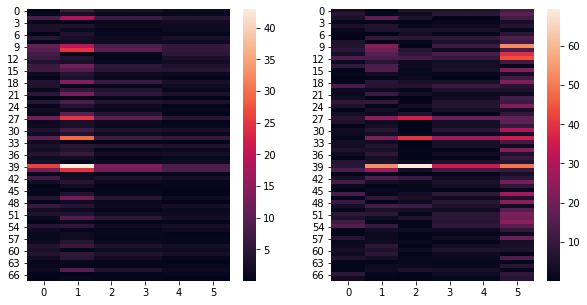

In [324]:
plt.figure(figsize=[10, 5])
plt.subplot(121)
sns.heatmap(np.abs(invU[:6, :]).T)
plt.subplot(122)
sns.heatmap(np.abs(einvU[:6, :]).T)

<AxesSubplot:>

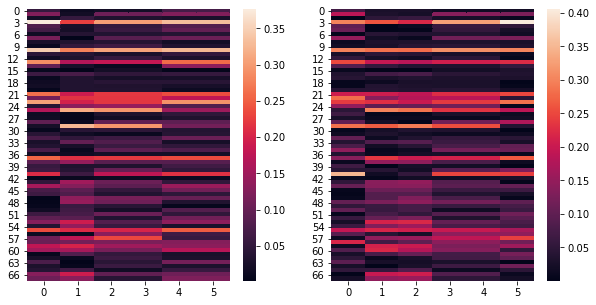

In [325]:
plt.figure(figsize=[10, 5])
plt.subplot(121)
sns.heatmap(np.abs(U[:, :6]))
plt.subplot(122)
sns.heatmap(np.abs(eU[:, :6]))

In [255]:
df = 0
dt = 0
hF, hT = hs
ts = times[dt]
fs = times[df]
t_diff = times - ts
freqs_diff = freqs- fs
Ytrans = Yt.permute((1, 2, 0))
Xtrans = Xt.permute((1, 2, 0))

kernelst = 1/np.sqrt(2*np.pi) * np.exp(-t_diff**2/2/hT**2) # normal_pdf(x/h)
kernelsf = 1/np.sqrt(2*np.pi) * np.exp(-freqs_diff**2/2/hF**2) # normal_pdf(x/h)
kernelst = torch.tensor(kernelst)
kernelsf = torch.tensor(kernelsf)

kernelroot = (kernelsf.unsqueeze(-1) * kernelst)  ** (1/2) #  dF x dT
kernelroot = torch.ones_like(kernelroot)

kerY = kernelroot.unsqueeze(-1)* (Ytrans) # dF x dT x d
kerX = kernelroot.unsqueeze(-1) * (Xtrans) # dF x dT x d
kerYmat = kerY.reshape(-1, d)
kerXmat = kerX.reshape(-1, d)

M = kerXmat.T.mm(kerXmat)/dF/dT
XY = kerYmat.T.mm(kerXmat)/dF/dT

invM = torch.inverse(M)
ecAmat =  XY.mm(invM)


cX = X[:, df, dt]
cMu = stdMus[:, df]
cNu = Nus[:, dt]
pEigVs = cMu * cNu
        # sortIdx = np.argsort(np.abs(pEigVs))[::-1]
cEigVs = np.diag(np.concatenate([pEigVs, np.zeros(num - len(cMu))]))
cA = np.matmul(np.matmul(U, cEigVs), invU)
cAr = cA.real # theroetically, imag part should be 0

In [256]:
kernelsf

tensor([3.7483e-01, 3.1091e-01, 1.7497e-01, 8.8363e-03, 5.9266e-12])

In [257]:
np.linalg.norm(cAr-ecAmat.cpu().numpy())

2668.9281387047718

In [76]:
fs = 600
Rn = nR
outIterC = 1e-6
lams = [1e1, 1e1]
q = 50
downrates = [1, 1]


T = 6
bandsCuts = [[2, 3.5], [4, 7], [8, 12], [13, 30], [30, 80]]
times = np.linspace(0, T, dT)
freqs = np.array([np.mean(bandCut) for bandCut in bandsCuts])
hs = [bw_nrd0_R(freqs), bw_nrd0_R(times)]

iterNums = [100, 100]
betas = [1, 1]
iterCs = [1e-8, 1e-8]
As = [2.7, 2.7]
alps = [0.9, 0.9]

In [77]:
class TVDNextOpt():
    """
        The class to implement the full procedure of TVDNext method
    """
    def __init__(self, rawDat, fs, T, Rn, hs, **paras):
        """
         Input: 
             rawDat: The raw dataset, tensor of d x dT+1
             fs: The sampling freq of the raw dataset
             T: Time course of the data
             Rn: The nominal rank of A mat, Rn << d to reduce the computational burden 
             hs: the bandwidths for the kernel regression whe estimating A matrix
             paras:
               For Preprocess:
                 is_detrend: Whether detrend the raw data or not
                 bandsCuts: the cirtical freqs to use
                 Nord: The order of the filter
                 q: The decimate rate
                 
               For A matrix:
                 downrates: The downrate factors for freq and time, determine how many A(s_i, t_i) matrix to be summed
                 
               For one-step Opt:
                 betas: list of two tuning parameter for iteration
                 alps: list of two tuning parameter for iteration
                 rhos: list of two vectors of length (dF-1)2R and (dT-1)2R, real data
                 lams: list of two parameters for SCAD, for mu and nu
                 As: list of two parameters for SCAD for mu and nu, > 1+1/beta
                 iterNums:  integer or list of two integers, number of iterations for one-step-opt
                 iterCs: decimal or list of two decimate, stopping rule for one-step-opt
               
               For the outer optimization procedure:
                 paraMuInit: The initial value of mu parameters, along the freq axis
                 paraNuInit: The initial value of nu parameters, along the time axis
                 maxIter: Integer, the maximal times of iteration for the outer loop
                 outIterC:  decimal, stopping rule for the outer loop
        """
        parasDefVs = {
                      "is_detrend": True, "bandsCuts": [[2, 3.5], [4, 7], [8, 12], [13, 30], [30, 80]], 
                      "Nord": None, "q": 10, 
                      "downrates": [1, 10],  "betas":[1, 1], "alps": [0.9, 0.9],  "rhos": None,  "lams": None, 
                      "As": [2.7, 2.7],  "iterNums": [5, 1], "iterCs": None, "paraMuInit": None,
                      "paraNuInit": None, "maxIter": 100, "outIterC": None
                    }
        self.paras = edict(parasDefVs)
        for key in paras.keys():
            self.paras[key] = paras[key]
            
        if self.paras.iterCs is None:
            self.paras.iterCs = [None, None]
        
            
        self.rawDat = rawDat
        self.fs, self.T = fs, T
        self.Rn = Rn
        self.hs = hs 
        
        # Some none definitions
        self.X = self.Y = self.pUinv = None
        self.dF = self.dT = self.D = self.nD = None
        self.lastThetaMu = self.lastTheteNu = None # Vector of 2R(dF-1)/2R(dT-1)
        self.paraMu = self.paraNu = None # matrix of 2R x dF/dT
        self.kpidx = None
        self.R = self.R2 = None
        self.U = None
        
    def _PreProcess(self):
        """
        To preprocess the raw dataset, including 
            1. Detrend, 
            2. Filter under bands
            3. Decimate
        """
        dat = signal.detrend(self.rawDat)
        cDat = mat2Tensor(dat, fs=self.fs, q=self.paras.q)
        # Avoid stride problem when convert numpy to tensor
        self.X = torch.tensor(cDat.X.copy())
        self.Y = torch.tensor(cDat.Y.copy())
        
    def _estAmat(self):
        _, self.dF, self.dT = self.Y.shape
        times = np.linspace(0, self.T, self.dT)
        freqs = np.array([np.mean(bandCut) for bandCut in self.paras.bandsCuts])
        if self.hs is None:
            self.hs = [bw_nrd0_R(freqs), bw_nrd0_R(times)]
        
        self.Amat, Amats = GetAmatTorch(self.Y, self.X, times, freqs, self.paras.downrates, self.hs)
        
        res = np.linalg.eig(self.Amat)
        absEigVs = np.abs(res[0])
        # Sort the eigvs and vectors such that the vals is in order
        sortIdx = np.argsort(absEigVs)[::-1]
        lams = res[0][sortIdx]
        U = res[1][:, sortIdx]
        self.U = U
        
        eigF = np.concatenate([[np.inf], lams])
        # To remove conjugate eigvector
        self.kpidx = np.arange(self.Rn)
        # self.kpidx = np.where(np.diff(np.abs(eigF))[:self.Rn] != 0)[0] 
        self.R = len(self.kpidx)
        self.R2 = 2 * self.R
        
        Uinv = np.linalg.inv(U)
        pUinv = Uinv[self.kpidx, :]
        self.pUinv = torch.tensor(pUinv)
        
    def __call__(self, showSubProg=False, **runParas):
        for key in runParas:
            self.paras[key] = runParas[key]
            
        if self.X is None:
            self._PreProcess()
        if self.pUinv is None:
            self._estAmat()
        
        _, self.dF, self.dT = self.X.shape
        
        self.D = self.dF
        self.nD = int(self.dF*self.dT/self.D)
        if self.paras.paraMuInit is None:
            self.paras.paraMuInit = torch.rand(self.R2, self.dF)
        if self.paras.paraNuInit is None:
            self.paras.paraNuInit = torch.rand(self.R2, self.dT)
        if self.paras.rhos is None:
            rho1 = torch.ones(self.R2*(self.dF-1))
            rho2 = torch.ones(self.R2*(self.dT-1))
            self.paras.rhos = [rho1, rho2]
            
        
        
        chDiffBoth = torch.tensor(1e10) # Stopping rule
        
        lastMuTheta = DiffMatOpt(colStackFn(self.paras.paraMuInit), self.R2)
        fixedNuMat = self.paras.paraNuInit
        
        stopLastMuMat = self.paras.paraMuInit
        stopLastNuMat = self.paras.paraNuInit
        
        pbar = tqdm(range(self.paras.maxIter))
        for i in pbar:
            if i == 0:
                pbar.set_description(f"Outer Loop: The chdiff is {chDiffBoth.item():.3e}.")
            else:
                pbar.set_description(f"Outer Loop:"
                                     f"{chDiffMu.item():.3e}, "
                                     f"{chDiffNu.item():.3e}, "
                                     f"{chDiffBoth.item():.3e}.")
            optMu = OneStepOpt(X=self.X, Y=self.Y, pUinv=self.pUinv, fixedParas=fixedNuMat, lastTheta=lastMuTheta, 
                               alp=self.paras.alps[0], beta=self.paras.betas[0], lam=self.paras.lams[0], 
                               a=self.paras.As[0], iterNum=self.paras.iterNums[0], rho=self.paras.rhos[0], iterC=self.paras.iterCs[0])
            optMu(showSubProg)
            
            fixedMuMat = optMu.GamMatStd
            if i == 0:
                lastNuTheta = DiffMatOpt(colStackFn(fixedNuMat), self.R2)
            else:
                lastNuTheta = optNu.lastTheta
            
            optNu = OneStepOpt(X=self.X, Y=self.Y, pUinv=self.pUinv, fixedParas=fixedMuMat, lastTheta=lastNuTheta, 
                               alp=self.paras.alps[1], beta=self.paras.betas[1], lam=self.paras.lams[1], 
                               a=self.paras.As[1], iterNum=self.paras.iterNums[1], rho=self.paras.rhos[1], iterC=self.paras.iterCs[1])
            optNu(showSubProg)
            
            fixedNuMat = optNu.GamMat
            # lastMuTheta = DiffMatOpt(colStackFn(fixedMuMat), self.R2)
            lastMuTheta = optMu.lastThetaStd
            
            chDiffMu = torch.norm(stopLastMuMat-fixedMuMat)/torch.norm(stopLastMuMat)
            chDiffNu = torch.norm(stopLastNuMat-fixedNuMat)/torch.norm(stopLastNuMat)
            chDiffBoth = torch.max(chDiffMu,chDiffNu)
            
            stopLastMuMat = fixedMuMat
            stopLastNuMat = fixedNuMat
            # if show_prog:
            #     if (i+1) % thin == 1:
            #         print(f"Current iteration is {i+1}/{self.paras.maxIter}, the change of diff is {chDiffBoth}")
            if chDiffBoth <= self.paras.outIterC:
                break
            
        self.paraMu = stopLastMuMat
        self.paraNu = stopLastNuMat
        self.lastOptMu = optMu
        self.lastOptNu = optNu

In [78]:
fOpt = TVDNextOpt(rawDat=None, fs=fs, T=T, hs=hs, Rn=Rn, lams=lams, downrates=downrates, q=q, 
                  iterNums=iterNums, iterCs=iterCs, As=As, alps=alps,
                  outIterC=outIterC, maxIter=1000, betas=betas)
fOpt.X = torch.tensor(X)
fOpt.Y = torch.tensor(Y)

In [79]:
fOpt._estAmat()

In [80]:
fOpt.pUinv = torch.tensor(invU[:6, :])

In [81]:
# res = np.linalg.eig(fOpt.Amat)

In [82]:
# absEigVs = np.abs(res[0])
# plt.subplot(121)
# plt.plot(np.log(absEigVs))
# plt.subplot(122)
# plt.plot(absEigVs)

In [83]:
# absEigVs

In [84]:
fOpt(True, maxIter=100)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [85]:
eMus = fOpt.lastOptMu.GamMatStd.cpu().numpy()
eThetas = fOpt.lastOptMu.ThetaMatStd.cpu().numpy()
tMus = np.concatenate([stdMus.real, stdMus.imag])
eDiffMus = np.diff(eMus)

([], [])

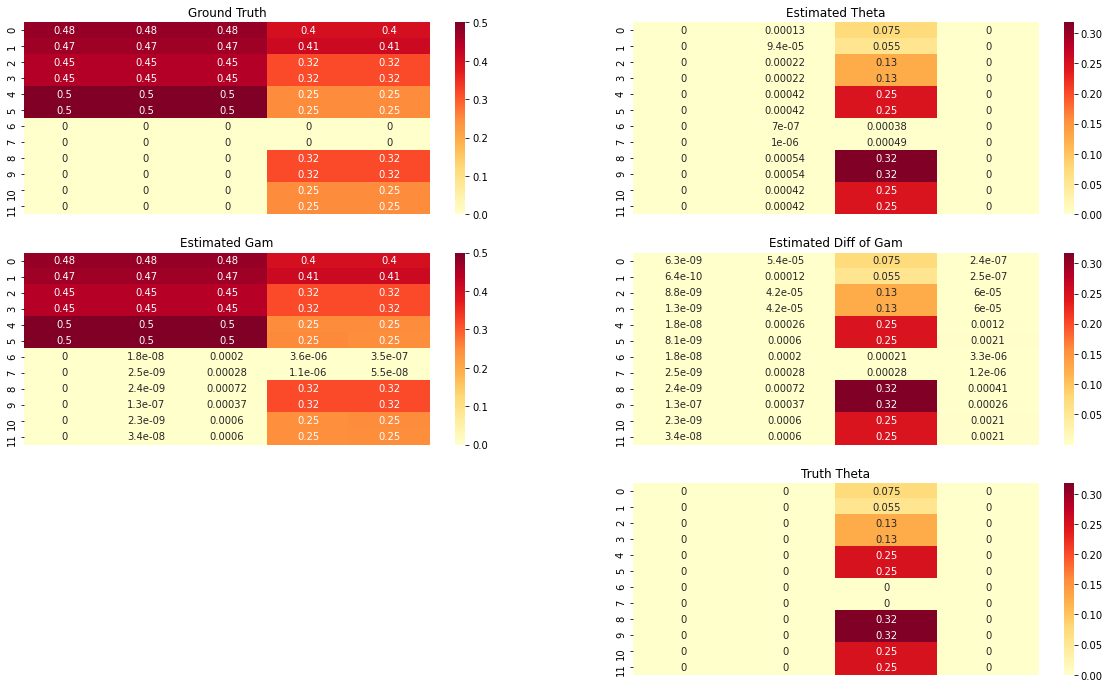

In [86]:
plt.figure(figsize=[20, 12])

is_annot = True
plt.subplot(321)
plt.title("Ground Truth")
sns.heatmap(np.abs(tMus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(323)
plt.title("Estimated Gam")
sns.heatmap(np.abs(eMus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

#plt.subplot(325)
#plt.title("Abs diff of eGam and tGam")
#sns.heatmap(np.abs(tMus-eMus), cmap="YlOrRd",  annot=is_annot)
#plt.xticks([])

plt.subplot(322)
plt.title("Estimated Theta")
sns.heatmap(np.abs(eThetas), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(324)
plt.title("Estimated Diff of Gam")
sns.heatmap(np.abs(eDiffMus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(326)
plt.title("Truth Theta")
sns.heatmap(np.abs(np.diff(tMus)), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

In [87]:
eNus = fOpt.lastOptNu.GamMat.cpu().numpy()
eThetas = fOpt.lastOptNu.ThetaMat.cpu().numpy()
tNus = np.concatenate([Nus.real, Nus.imag])
eDiffNus = np.diff(eNus)

([], [])

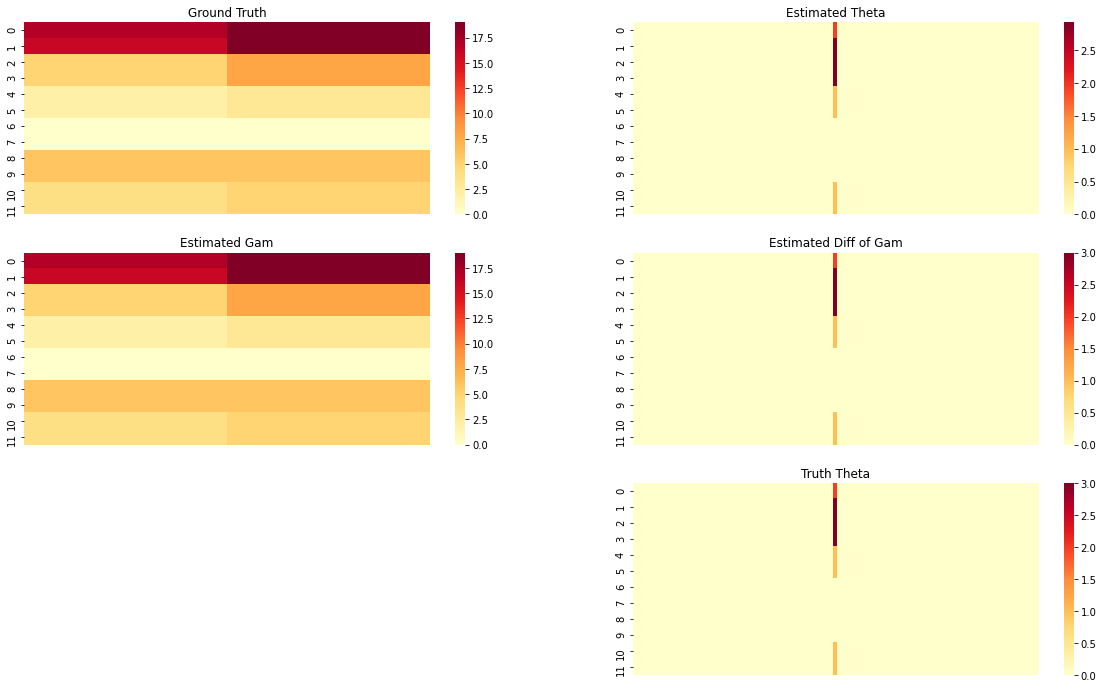

In [88]:
plt.figure(figsize=[20, 12])

is_annot = False
plt.subplot(321)
plt.title("Ground Truth")
sns.heatmap(np.abs(tNus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(323)
plt.title("Estimated Gam")
sns.heatmap(np.abs(eNus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

# plt.subplot(325)
# plt.title("Abs diff of eGam and tGam")
# sns.heatmap(np.abs(tNus-eNus), cmap="YlOrRd",  annot=is_annot)
# plt.xticks([])

plt.subplot(322)
plt.title("Estimated Theta")
sns.heatmap(np.abs(eThetas), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(324)
plt.title("Estimated Diff of Gam")
sns.heatmap(np.abs(eDiffNus), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])

plt.subplot(326)
plt.title("Truth Theta")
sns.heatmap(np.abs(np.diff(tNus)), cmap="YlOrRd",  annot=is_annot)
plt.xticks([])